# Apply Constraints

## Commodity production 

Now we can extend winter cereal's yield to 2050 by multiplying its yield in 2010 with climate change's impact in 2050 (in the below map).

In [22]:
# REMOVE
yr_idx = year_target - year_begin
# Get the quantity matrices
q_mrp = get_quantity_matrices(data, yr_idx).astype(np.float32)          # t/cell
q_mrp_xr = mrj_to_xr(data, q_mrp).expand_dims({'year': [year_target]})  

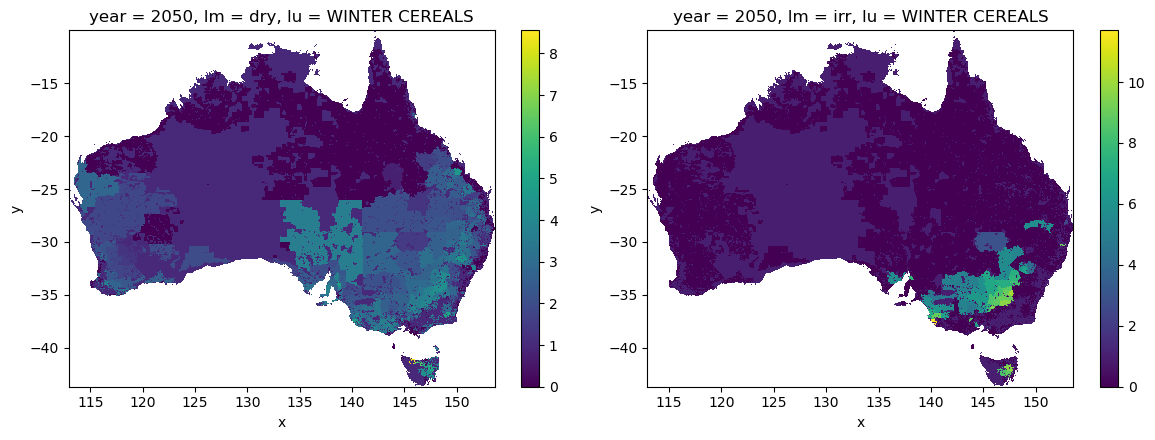

In [23]:
# HIDE CODE
q_lu_target = q_mrp_xr / lu_area  # t/ha

q_dry_target = q_lu_target.sel(lm='dry', lu=lu_desc.upper(), year=year_target).drop_vars('spatial_ref')
q_irr_target = q_lu_target.sel(lm='irr', lu=lu_desc.upper(), year=year_target).drop_vars('spatial_ref')
plot_dry_irr(q_dry_target, q_irr_target)

Let's use winter cereal's spatial distribution in 2010 and its yield of 2050 to get the production in 2050. If the result is larger than demand, that means we do not need to do anything to winter cereal; otherwise, we need to rearrange its spatial distribution to meet the demand of 2050.

```{note}
To get the production, we simply need to apply below function: `production` = `land-use map` * `yield map`. However, there are a few things need to keep in mind:
- The `land-use map` is just a spatial indication of how the land is used. It does not have any physical meaning attached.
- `yield map` is a physical indication of 'tonnes/hactor'
- We need to assign the `area (hactor)/cell` information to land-use map so that the result will be a production (`tonnes/cell`)
```


LUTO has a `data.REAL_AREA` variable that stores the true area (hactor) for each cell. In order to get winter cereal's production, we need to include this data in the formulation `production (tonne/ha)` = `land-use map` * `area map (ha/cell)` * `yield map (tonne/ha)` for a correct calculation. Have a think about why the area in the north part is larger than the south (LUTO uses the 'Geocentric Datum of Australia (GDA) 1994 coordinate system).

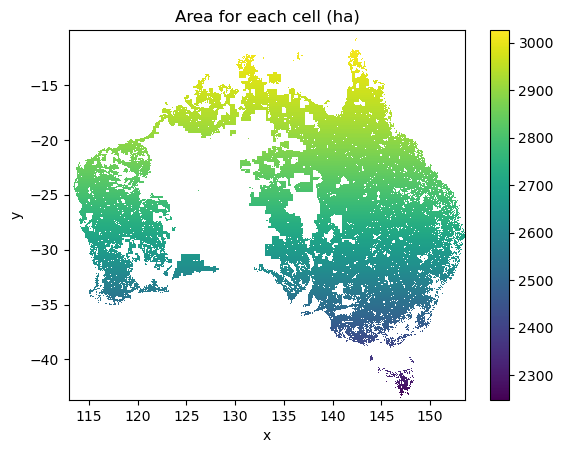

In [24]:
# HIDE CODE
lu_area.where(lu_mask == 1).plot()
plt.title('Area for each cell (ha)')
plt.show()

In [25]:
# HIDE CODE

# Calculate the total quantity for each water supply
q_dry_total = lu_arr_dry.values * lu_area.values * q_dry_target.values * lu_mask.values      
q_dry_total = np.nansum(q_dry_total) / 1e6          # million t               

q_irr_total = lu_arr_irr.values * lu_area.values * q_irr_target.values * lu_mask.values   
q_irr_total = np.nansum(q_irr_total) / 1e6          # million t 

# Get the total quantity for the given land-use
q_total = q_dry_total + q_irr_total                 # million t       

print(f'Total quantity for {lu_desc} in {year_target}: {q_total:.2f} million tonnes.') 

Total quantity for Winter cereals in 2050: 51.00 million tonnes.


Recall that the demand for winter cereal will be 77.31 million tonness in 2050 and there will be a 26.31 million metric tons shortage based on winter cereal's 2010 spatial distribution. Therefore, we need to increase winter cereal's plantation to fill this gap.

To make it simple, let's gradually close the demand gap by randomly adding cells to the winter cereal's map of 2010:
1) Randomly select and add 10 cells to both dry and irrigated winter cereal map for 2010
2) Reduce the demand gap by subtracting the production from these 10 newly added cells
3) If the demand was closed, then stop this random cell addition
4) If the demand still exist, then start another round of random cell addition

```{note}
In this example, we use the random cell addition method to simplify the process of finding a solution. In LUTO, we utilize a commercial solver called [Gurobi](https://www.gurobi.com/) to find the optimal solution. The detailed implementation can be found [here](https://github.com/land-use-trade-offs/luto-2.0/blob/master/luto/solvers/solver.py).
```

In [26]:
# REMOVE

# Get the available land for the given land-use
lu_arr_dry_aval = (lu_arr_dry == 0) * (lu_arr_irr != 1) * (q_dry_target > 0)
lu_arr_irr_aval = (lu_arr_irr == 0) * (lu_arr_dry != 1) * (q_irr_target > 0)

In [27]:
# REMOVE

def rand_reduce_gap(in_dry, in_irr, q_dry, q_irr, gap, chunk_size=10):

    # Get the row/col for the non-zero values
    row_dry, col_dry = np.nonzero(in_dry)
    row_irr, col_irr = np.nonzero(in_irr)

    # Get the index for the non-zero values
    idx_dry = list(range(len(row_dry)))
    idx_irr = list(range(len(row_irr)))
    
    # Initialize the selected index
    sel_idx_dry = []
    sel_idx_irr = []
    
    # Loop until the gap is closed
    while gap>= 0:
        if len(idx_dry) <= chunk_size or len(idx_irr) <= chunk_size:
            print('Not enought land for the meeting the production gap.')
            break
        
        sel_dry = np.random.choice(idx_dry, chunk_size, replace=False)
        sel_irr = np.random.choice(idx_irr, chunk_size, replace=False)
        
        [idx_dry.remove(i) for i in sel_dry]
        [idx_irr.remove(i) for i in sel_irr]
        
        sel_idx_dry.extend(sel_dry)
        sel_idx_irr.extend(sel_irr)
        
        gap -= np.nansum(q_dry.values[row_dry.values[sel_dry], col_dry.values[sel_dry]])
        gap -= np.nansum(q_irr.values[row_irr.values[sel_irr], col_irr.values[sel_irr]])
        
    # Get the pred array
    pred_arr_dry = lu_arr_dry.copy()
    pred_arr_irr = lu_arr_irr.copy()
    
    pred_arr_dry.values[row_dry.values[sel_idx_dry], col_dry.values[sel_idx_dry]] = 2
    pred_arr_irr.values[row_irr.values[sel_idx_irr], col_irr.values[sel_idx_irr]] = 2
           
    return pred_arr_dry, pred_arr_irr

In [28]:
# REMOVE

# Randomly select from available land to meet the production gap
from joblib import Parallel, delayed 
from tqdm.auto import tqdm  

n_runs = 100     

gap = (demand_vol - q_total) * 1e6              # tonnes
q_dry_cell = q_dry_target * lu_area             # t/cell
q_irr_cell = q_irr_target * lu_area             # t/cell

para_obj = Parallel(n_jobs=20, return_as='generator')
tasks = (delayed(rand_reduce_gap)(lu_arr_dry_aval, lu_arr_irr_aval, q_dry_cell, q_irr_cell, gap, chunk_size=10) for _ in range(n_runs))
results = [i for i in tqdm(para_obj(tasks), total=n_runs)]

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
# REMOVE

# Combine all results to one xarray object
pred_arr_xr = []
for i,arr in enumerate(results):
    dry_arr = arr[0].expand_dims({'run': [i], 'lm':['dry']},)
    irr_arr = arr[1].expand_dims({'run': [i], 'lm':['irr']},)
    pred_arr_xr.append(dry_arr)
    pred_arr_xr.append(irr_arr)

# Combine the xarray objects
pred_arr_xr = xr.combine_by_coords(pred_arr_xr)   

Here, we repeat the random process 100 times so that we can illustrate how LUTO finds the best solution under various constraints and objective functions. Below are the simulated results stored in a `xarray.DataArray`, we can see that `run: 100` indicates there are 100 runs, `lm: 2` means each run includes a dry and an irrigated result, and `x` and `y` are the height and weight of each result.

In [30]:
# HIDE CODE
pred_arr_xr['data']

<xarray.DataArray 'data' (run: 100, lm: 2, y: 673, x: 814)> Size: 438MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
...
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * run          (run) int32 400B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * lm           (lm) object 16B 'dry' 'irr'
    lu           <U14 56B 'Winter cereals'
  * x            (x) float64 7kB 113.0 113.0 113.0 113.1 ... 153.5 153.6 153.6
  * y            (y) float64 5kB -10.04 -10.09 -10.14 ... -43.54 -43.59 -43.64
    spatial_ref  int32 4B 0

Let's plot the first solution (run = 0) and compare it with the original land-use map. We can see the randomly added pixel of dryland winter cereal scattered across south Australia, and the irrigated winter cereal is more closely aggregated around in the sourtheast. Remember, this is just one solution out of the 100 runs. The question is: how do you find the best one? The general idea is that we will calculate the water consumption, GHG emissions, and biodiversity contribution to exclude solutions we can't accept, and finally use revenue/cost to get the solution with the minimized cost or maximized profit. 

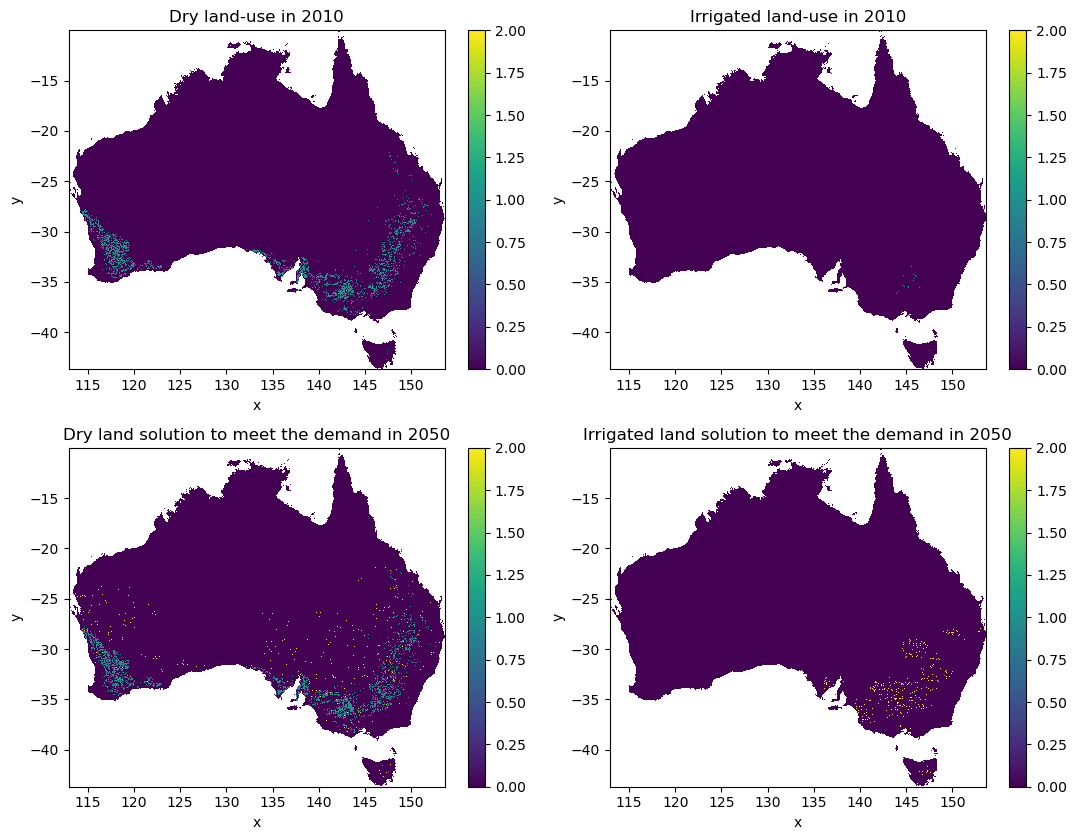

In [31]:
# HIDE CODE

fig, axs = plt.subplots(2,2, figsize=(11, 8.5), dpi=100)
axs = np.array(axs).flatten()

(lu_arr_dry * lu_mask).plot(ax=axs[0], vmax=2)
axs[0].set_title('Dry land-use in 2010')

(lu_arr_irr * lu_mask).plot(ax=axs[1], vmax=2)
axs[1].set_title('Irrigated land-use in 2010')

(pred_arr_xr['data'].sel(lm='dry', run=0) * lu_mask).plot(ax=axs[2])
axs[2].set_title('Dry land solution to meet the demand in 2050')

(pred_arr_xr['data'].sel(lm='irr', run=0) * lu_mask).plot(ax=axs[3])
axs[3].set_title('Irrigated land solution to meet the demand in 2050')

plt.tight_layout()


## Water Requirement

In [32]:
# REMOVE
wr_mrj = get_wreq_matrices(data, year_target - year_begin)              # ML/cell
wr_mrj_xr = mrj_to_xr(data, wr_mrj) / lu_area * lu_mask                 # ML/ha

wr_mrj_xr_lu = wr_mrj_xr.sel(lu=lu_desc)

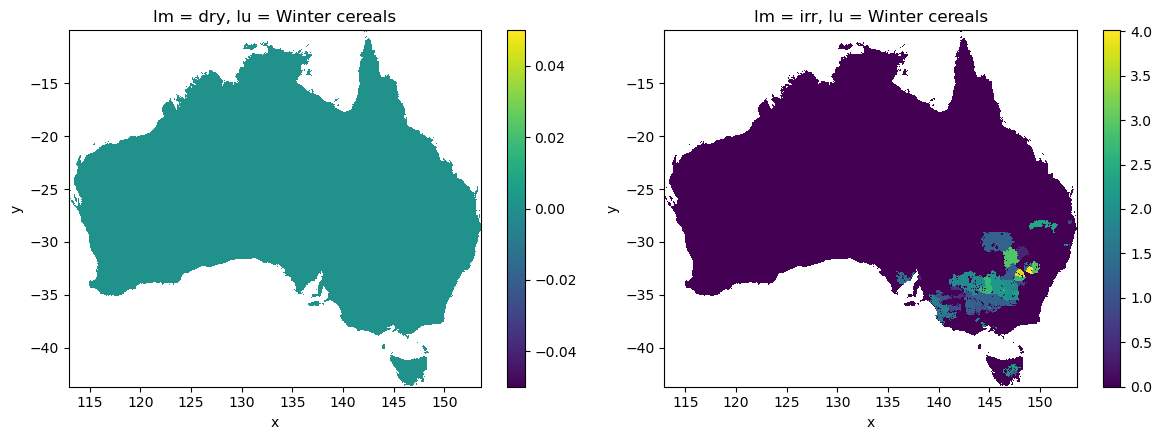

In [33]:
# HIDE CODE
wr_dry = wr_mrj_xr_lu.sel(lm='dry').drop_vars('spatial_ref')
wr_irr = wr_mrj_xr_lu.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(wr_dry, wr_irr)

## Costs and Revenues

In [34]:
# REMOVE

# Area Cost, Fixed Depreciation Cost, Fixed Labour Cost, Fixed Operating Cost   
c_fix = agec_crops_xr_lu.sel(Type=['AC', 'FDC', 'FLC', 'FOC'])       # $/ha

# Quantity Cost
c_q = agec_crops_xr_lu.sel(Type='QC') * q_lu_target                  # $/ha

# Water Cost
c_wr = agec_crops_xr_lu.sel(Type='WP') * wr_mrj_xr_lu                # $/ha          

# Revenue
r = agec_crops_xr_lu.sel(Type='P1') * q_lu_target                    # $/ha   


###########    Total Cost    ###########
c_total = c_fix.sum(dim='Type') + c_q + c_wr                         # $/ha  

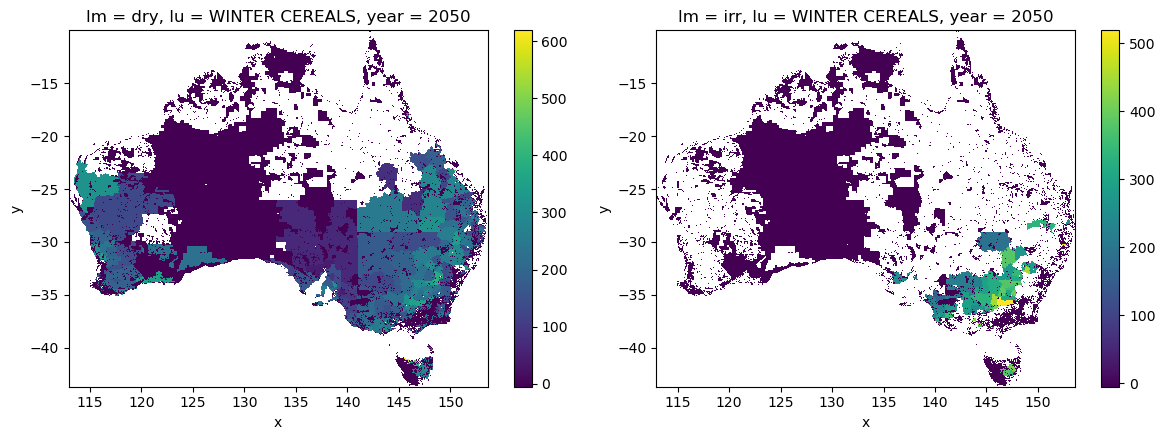

In [39]:
# HIDE CODE

c_arr = c_total.sel(lu=lu_desc.upper()).drop_vars('spatial_ref')

# REMOVE
c_dry = c_arr.sel(lm='dry')
c_irr = c_arr.sel(lm='irr')

plot_dry_irr(c_dry, c_irr)

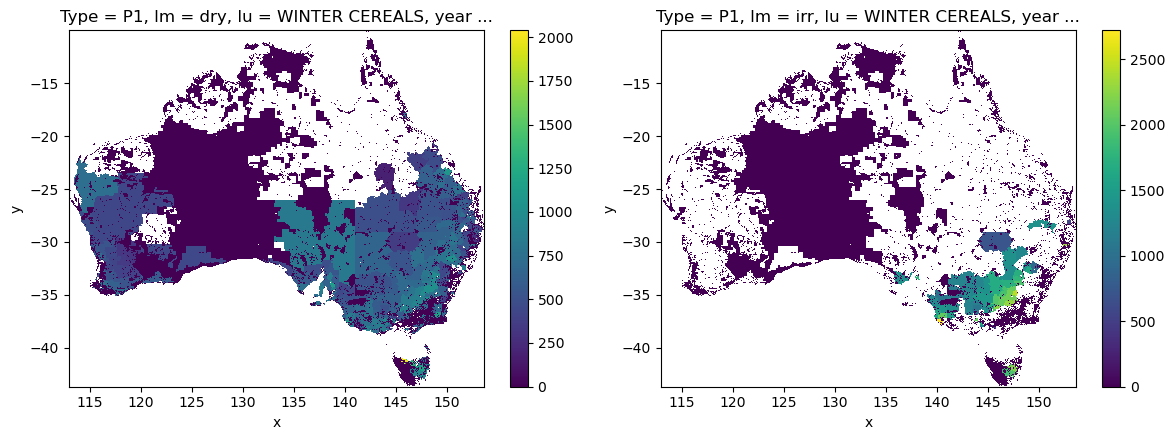

In [45]:
# HIDE CODE

r_dry = r.sel(lm='dry', lu=lu_desc.upper()).drop_vars('spatial_ref')
r_irr = r.sel(lm='irr', lu=lu_desc.upper()).drop_vars('spatial_ref')

plot_dry_irr(r_dry, r_irr)

## GHG emmisions

In [46]:
# REMOVE

# Convert the `AGEC_CROPS` data to 2D xarray
agghg_crops_xr = []
for col in data.AGGHG_CROPS.columns:
    series = data.AGGHG_CROPS[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'Type': [col[0]], 
        'lm': [col[1]], 
        'lu': [col[2]]
    })
    agghg_crops_xr.append(series_xr)

# Combine the xarray objects
agghg_crops_xr = xr.combine_by_coords(agghg_crops_xr)            # kg/ha

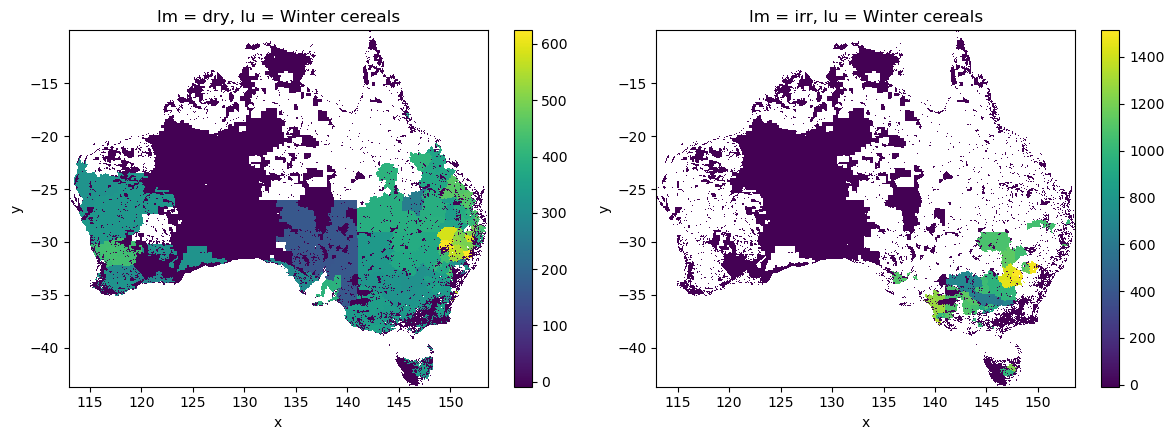

In [47]:
# HIDE CODE
agghg_crops_xr_lu = agghg_crops_xr.sel(lu=lu_desc).sum(dim=['Type'], skipna=False)    # kg/ha
ghg_dry = agghg_crops_xr_lu.sel(lm='dry').drop_vars('spatial_ref') 
ghg_irr = agghg_crops_xr_lu.sel(lm='irr').drop_vars('spatial_ref') 

plot_dry_irr(ghg_dry, ghg_irr)

## Find the optimized solution

In [48]:
# REMOVE

c_pred_xr = c_total * lu_area * pred_arr_xr
c_pred_xr_sum = c_pred_xr.sum(dim=['lm','x', 'y']) / 1e9        # billion $

r_pred_xr = r * lu_area * pred_arr_xr
r_pred_xr_sum = r_pred_xr.sum(dim=['lm','x', 'y']) / 1e9        # billion $

wr_pred_xr = wr_mrj_xr_lu * lu_area * pred_arr_xr               
wr_pred_xr_sum = wr_pred_xr.sum(dim=['lm','x', 'y']) / 1e6      # million ML

ghg_pred_xr = agghg_crops_xr_lu * lu_area * pred_arr_xr         
ghg_pred_xr_sum = ghg_pred_xr.sum(dim=['lm','x', 'y']) / 1e9    # million t

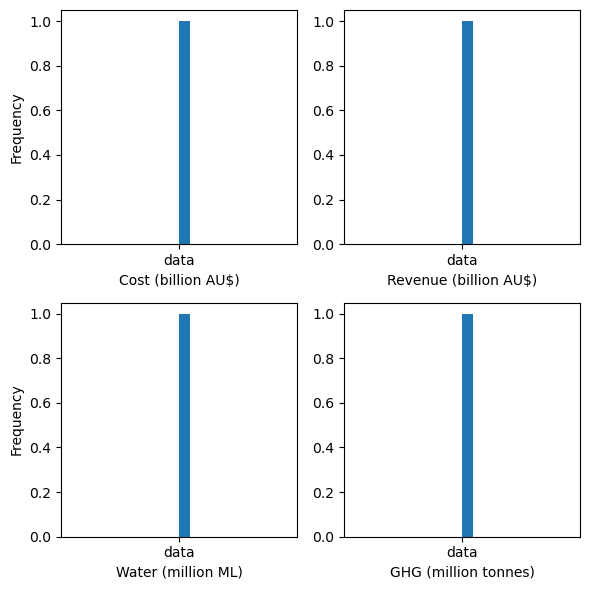

In [49]:
# HIDE CODE

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()


axs[0].set_ylabel('Frequency')
axs[0].hist(c_pred_xr_sum, bins=20)
axs[0].set_xlabel('Cost (billion AU$)')

axs[1].hist(r_pred_xr_sum, bins=20)
axs[1].set_xlabel('Revenue (billion AU$)')

axs[2].set_ylabel('Frequency')
axs[2].hist(wr_pred_xr_sum, bins=20)
axs[2].set_xlabel('Water (million ML)')

axs[3].hist(ghg_pred_xr_sum, bins=20)
axs[3].set_xlabel('GHG (million tonnes)')


plt.tight_layout()

In [50]:
# REMOVE

# Set abitrairy water and GHG limits
ghg_lmt = 18.8           # million tonnes
water_lmt = 15           # million ML

runs_lmt = (ghg_pred_xr_sum < ghg_lmt) & (wr_pred_xr_sum < water_lmt)
runs_idx = ghg_pred_xr_sum.coords['run'].values[runs_lmt.values]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [52]:
runs_lmt

<xarray.Dataset> Size: 560B
Dimensions:      (run: 100)
Coordinates:
  * run          (run) int32 400B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
    lu           <U14 56B 'Winter cereals'
    spatial_ref  int32 4B 0
Data variables:
    data         (run) bool 100B True True True True ... True True True True

In [51]:
ghg_pred_xr_sum

<xarray.Dataset> Size: 860B
Dimensions:      (run: 100)
Coordinates:
  * run          (run) int32 400B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
    lu           <U14 56B 'Winter cereals'
    spatial_ref  int32 4B 0
Data variables:
    data         (run) float32 400B 15.63 15.61 15.67 ... 15.87 15.76 15.84

In [ ]:
# HIDE CODE

c_df = c_pred_xr_sum[runs_idx].to_dataframe(name='Cost_billion_AUD').reset_index()
r_df = r_pred_xr_sum[runs_idx].to_dataframe(name='Revenue_billion_AUD').reset_index()

c_r_df = pd.merge(c_df, r_df, on=['run'], how='inner')[['run', 'Cost_billion_AUD', 'Revenue_billion_AUD']]
c_r_df['Profit_billion_AUD'] = c_r_df['Revenue_billion_AUD'] - c_r_df['Cost_billion_AUD']
c_r_df

In [ ]:
# HIDE CODE

c_min_idx = c_r_df['Cost_billion_AUD'].argmin()
c_min_run = c_r_df['run'][c_min_idx]

p_max_idx = c_r_df['Profit_billion_AUD'].argmax()
p_max_run = c_r_df['run'][p_max_idx]

print(f'The run with the minimum cost is {c_min_run}.\nThe run with the maximum profit is {p_max_run}.')

In [ ]:
# HIDE CODE

pred_min_c = pred_arr_xr.sel(run=c_min_run)
pred_min_c_dry = pred_min_c.sel(lm='dry').drop_vars('spatial_ref')
pred_min_c_irr = pred_min_c.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(pred_min_c_dry, pred_min_c_irr)

In [ ]:
# HIDE CODE

pred_max_p = pred_arr_xr.sel(run=p_max_run)
pred_max_p_dry = pred_max_p.sel(lm='dry').drop_vars('spatial_ref')
pred_max_p_irr = pred_max_p.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(pred_max_p_dry, pred_max_p_irr)